# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import h5py
import copy
import random
import pandas as pd
import keras_tuner as kt
import pandas as pd
from scipy import stats
from numba import cuda
from sklearn.model_selection import train_test_split as _train_test_split

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow_probability import distributions
from tensorflow_probability import math
from tensorflow_probability import distributions
from tensorflow_probability import math as tfpmath

# workaround to import pdn and CLR from another forlder while they are not installed
import sys
sys.path.insert(0,'../ML_tracer_painting/')
sys.path.insert(0,'./')

#import pdn
import clr_callback as CLR

tf.config.optimizer.set_jit(True)  #setting the XLA (Accelerated Linear Algebra) flag 


2023-11-24 17:36:10.234277: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 17:36:10.279467: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-24 17:36:10.279507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-24 17:36:10.279518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 17:36:10.287677: I tensorflow/core/platform/cpu_feature_g

In [2]:
%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [3]:
directory_path = "/home/ubuntu/" # add path to the data directory

## Loading the Data

I am trying to have a single dataframe with all the normalised parameters and the powerspectrums. There are 2k rows for the 2k Latin hypercube simulations. The frist five columns represent the normalised 5 Vanilla $\Lambda CDM$ model - $\Omega_m$,$\Omega_b$, $h$,$n_s$,$\sigma_8$respectively and the next columns are the values of the matter power spectrum at different scales.

In [4]:
# Reading the data

pk = pd.read_csv(directory_path+"Pk_lh.csv")[:32].T                      # taking transpose to keep in check the dimensionality
pk.reset_index(drop = True,inplace=True)                            # dropiing index for concatenating the P_k data with the parameters 
params = pd.read_csv(directory_path+"lh_params.csv",index_col= 0)   # laoding the vanilla parameters data

#normalising the parameters
mean_params = params.mean(axis=0).values
std_params = params.std(axis = 0).values
norm_params = (params - mean_params)/std_params

# Concatenating the params and pk

df = pd.concat([norm_params,pk],axis = 1)


P_k = df[df.columns[5:]]
van_labels = df[df.columns[:5]]


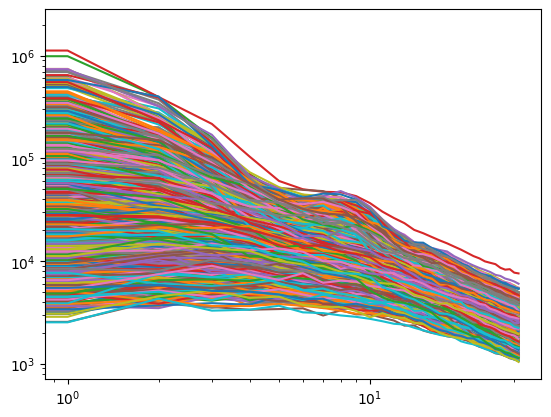

In [5]:
plt.plot(P_k.T)

plt.loglog()
plt.show()

The first 5 columns of our data set $("df")$ are the labels which are the the normalised 5 Vanilla $\Lambda CDM$ model and the rest are the Power spectrum values $P_{K}$. Now, we split the data into training set, validation set and test set. Here, I am permuting the dataset to avoid any bias.

In [6]:
def train_val_test_split(df,params = 5,random_state =1, train_frac = 0.6,test_frac = 0.2):
    # Permuting the DataFrame.
    
    df = df.sample(frac=1,random_state=random_state) 

    #seperating the input and labels in the df

    X = df[df.columns[params:]]
    y = df[df.columns[:params]]
    


    # Splitting into training, test and validation

    train_frac = train_frac
    test_frac =  test_frac
    val_frac = 1- (train_frac+test_frac)
    
#     assert train_frac + val_frac + test_frac == 1,"Fraction should add up to 1" # to ensure that the sum is one

    # defining the size for training, test and validation
    
    train_size, test_size, val_size = map(lambda frac: round(len(df) * frac), [train_frac, test_frac, val_frac])

    X_train, X_val, X_test, y_train, y_val, y_test = X[:train_size],X[train_size:train_size+test_size],X[train_size+test_size:],\
                                                     y[:train_size],y[train_size:train_size+test_size],y[train_size+test_size:]
    
    return(X_train, X_val, X_test, y_train, y_val, y_test)

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df)
y_train


,Omega_m,Omega_b,h,n_s,sigma_8
674,1.602612,-0.194807,-0.785289,0.778362,-1.017326
1699,-1.212998,0.894381,-1.088322,-0.946329,-1.038105
1282,-1.318627,-0.847627,1.225120,-1.510837,-1.235509
1315,-0.684855,0.125542,0.580958,-1.391355,0.778362
1210,0.125542,-1.209535,-1.315164,-1.124686,-0.665807
...,...,...,...,...,...
752,0.341995,-0.535936,-1.384429,0.071862,0.109958
121,-0.397406,-0.049351,0.863212,-0.468403,0.709098
699,-0.037230,1.476204,-1.536811,0.790484,0.052814
876,0.683123,-0.504767,1.076201,1.226851,0.378359


# Define couple of useful functions

#### Defining the loss plot function

In [8]:
# Function defining loss plot.

def plot_loss(histories, ylim=None, logy=False):
    plt.figure(figsize=(12,8 ))
    
    plt.plot(histories.index, df_history['loss'], label='Training_loss')
    plt.plot(histories.index, df_history['val_loss'], label='Validation_loss')

    
#     for key, history in histories.items():
#         plt.plot(
#             np.array(range(len(history.history['val_loss'])))-0.5, 
#             history.history['loss'], 
#             label='loss'
#         )
#         plt.plot(history.history['val_loss'], label='val_loss')

    if logy:
        plt.semilogy()
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
#     print(key)
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()

#### LaTex Label Names

In [9]:
label_LaTeX_names_vanilla = [
    r"$\Omega_m$",
    r"$\Omega_b$",
    r"$h$",
    r"$n_s$",
    r"$\sigma_8$"
]

#### Defining Elu+1 activation function
Used for positive definiteness of the Sigma outputs. ELU gives a negative output however for the sigma values we need a positive definiteness so ELU+1 helps with that

In [10]:
def elu_plus_one(input):

    """ Adds one to the Exponential Linear Unit

    """

    return tf.add(

       tf.nn.elu(input),

        tf.constant(1.0000001, dtype=tf.float32) # Notice I added 1.e-7 for stability

    )

tf.keras.utils.get_custom_objects().update({'elu_plus_one': layers.Activation(elu_plus_one)})

# Analysis

## Building the model
Creating layers and defining hyperparameter tuninig. Also defined ELU+1 activation funtion

In [11]:
# training_set_properties = X_train #data_LH_vanilla["P0"]["train"]["ftr"]



# def elu_plus_one(x):
#     return (tf.keras.activations.elu(x)+1)

def model_build(hp):

    
#############################   Hyper-tuning Parameters  #############################  
    num_layers = hp.Int('num_layers', min_value=1, max_value=4)
    
    architecture = [hp.Int(f"unit_num_{i}", min_value = 32,
                           max_value = 512, step = 32) for i in range(num_layers)]
    
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    
    
    
#############################   Creating Layers  #############################
    
    # The features are normalized to have mean=0 and std=1
    inputs = Input(shape=X_train.shape[1])
    normalize_layer = layers.Normalization()
    normalize_layer.adapt(X_train)
    norm_inputs = normalize_layer(inputs)
    input_layer = norm_inputs

    
    # Adding hidden dense layers which is specified by the architecture in our case it is 3 layers with 32 neurons each
  

    for n_nodes in architecture:
        d_layer = layers.Dense(n_nodes,
                              activation="selu",
                              kernel_initializer="he_normal",)(input_layer)

        
    # Each is followed by a dropout layer  to apply dropout regularisation to the o/p of the d_layer which is then assigned to the input_layer for the next iteration which is the two dense layer mean and sigma our output layers
        
        
        input_layer = layers.Dropout(dropout_rate)(d_layer)


    # Add the output layer combining means and sigmas
   
    
    means = layers.Dense(
        5,
        activation="linear",
        kernel_initializer="he_normal",
    )(input_layer)

    sigmas = layers.Dense(
        5, 
        activation="elu_plus_one", # ????is there any particular reason for using elu+1? - yes as it is an exponential function so doest return 0 for a negative function.
        kernel_initializer="he_normal",
    )(input_layer)

    output_layer = layers.Concatenate()([means, sigmas])


#############################   Creating Model  #############################
    
    
    model = Model(inputs=inputs, outputs=output_layer)
    
    
    model.compile(
        loss=mse_means_and_sigmas_uncorrelated,
        optimizer=tf.optimizers.Adam(learning_rate = learning_rate ),
        #optimizer=tf.optimizers.Adam(learning_rate=1.e-3),
    )
    # model.summary()
    
    return model

## Defining loss

In [12]:
def mse_means_and_sigmas_uncorrelated(y_true, y_pred):
    means_pred, sigmas_pred = tf.split(y_pred, num_or_size_splits=2, axis=1)
    
    y_true = tf.cast(y_true, dtype=y_pred.dtype) #????? 
    
    squared_differences = tf.math.square(y_true - means_pred)
    sigmas2_sigma = tf.math.reduce_mean(tf.math.square(squared_differences - tf.math.square(sigmas_pred)), 0)
    sigmas2 = tf.math.reduce_mean(squared_differences, 0) 

    loss = tf.math.reduce_mean(tf.math.log(sigmas2) + tf.math.log(sigmas2_sigma))
    #loss = tf.math.reduce_mean(sigmas2 + sigmas2_sigma)

    return loss

Create model

## Define callbacks

In [13]:
# Definfing callbacks using cyclic learning rate in our case

max_lr = 1.e-3
clr_triangular = CLR.CyclicLR(#mode='exp_range',
                              base_lr=max_lr/4.,
                              max_lr=max_lr,
                              step_size=3*4, # recommended (2-8) x (training iterations in epoch)
                              gamma=0.99994)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100, #The number pavid people that want to do better than 10 but not commit to 100 use.
    restore_best_weights=True,
    verbose=0,
)

## Define some ancillary stuff

In [14]:
def check_predictions(trueY, predicY, predicE, label='quantity [some units]', numbins=100, title=None):
    fig, ax = plt.subplots(ncols=3,sharex=True,figsize=(9,2.8))#6.4,2.8 #6.4,4.8

    ax[0].errorbar(
        x=trueY[:], y=predicY,
        yerr=predicE,
        elinewidth=0.5,
        linewidth=0,
        #bins='log', xscale='log', yscale='log',
        #gridsize=numbins
    )
    extremes = [np.min([trueY, predicY]),np.max([trueY, predicY])]    
    ax[0].set_xlabel('True '+label)
    ax[0].set_ylabel('Predicted '+label)
    ax[0].plot(extremes, extremes, c='k')
    ax[0].set_xlim(extremes[0], extremes[1])
    ax[0].set_ylim(extremes[0], extremes[1])
    ax[0].set_aspect('equal', adjustable='box')
    
    ymean = np.mean(trueY)
    R2 = 1.-np.sum((trueY-predicY)**2) / np.sum((trueY-ymean)**2)
    
    ax[0].text(0.975, 0.025, r'$R^2$=%.2f'
               "\n"
               r"$\chi^2$=%.2f" %(R2, np.sum((trueY - predicY)**2/predicE**2)/(len(predicE)-2)),
               style='italic', transform=ax[0].transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2}, ha="right", va="bottom")
    
    ax[1].plot(trueY, predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[1].set_xlabel('True '+label)
    ax[1].set_ylabel('Standard deviation')
    ax[1].text(0.975, 0.025, r'$\langle\sigma \rangle$=%.2f'
               "\n"
               r"RMSE=%.2f" %(np.mean(predicE), np.sqrt(np.mean((predicY-trueY)**2))), 
               style='italic', transform=ax[1].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    
    ax[2].plot(trueY, (predicY-trueY)/predicE, marker=".", lw=0, markersize=2, alpha=1)
    ax[2].set_xlabel('True '+label)
    ax[2].set_ylabel(r'Bias [$\sigma$]')
    ax[2].grid(axis="y",alpha=0.5,ls="--")
    ax[2].text(0.975, 0.025, r"$\langle bias \rangle$=%.2f"
               "\n"
               r"$\langle |bias| \rangle$=%.2f" % (np.mean((predicY-trueY)/predicE), np.mean(np.abs(predicY-trueY)/predicE)), 
               style='italic', transform=ax[2].transAxes,
               bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2},
               ha="right", va="bottom")
    plt.tight_layout()
    
    if title is not None:
        plt.subplots_adjust(left=0.1, right=0.975, top=0.9, bottom=0.2)
        plt.suptitle(title)#, fontdict={'horizontalalignment': "center"})
    else:
        plt.subplots_adjust(left=0.05, right=0.975, top=0.975, bottom=0.2)
    fig.show()

# Tuning hyperparameters

In [15]:
# Instantiating the tuner
tuner = kt.Hyperband(
    model_build,
    objective= 'val_loss',
    max_epochs = 100,
    directory='keras_tuner_dir',
    project_name='hyperband_tuning')
# Running the HyperParameter Search

tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=100000, callbacks=[clr_triangular, early_stopping])





Trial 254 Complete [00h 00m 24s]
val_loss: -4.831604957580566

Best val_loss So Far: -5.697732925415039
Total elapsed time: 00h 24m 44s


Let us see the best hypertune parameters

In [16]:
best_hp=tuner.get_best_hyperparameters(num_trials=1)[0]

best_num_layers = best_hp.get('num_layers')
best_architecture = [best_hp.get(f"unit_num_{i}") for i in range(best_num_layers)]
best_learning_rate = best_hp.get('learning_rate')
best_dropout_rate = best_hp.get('dropout_rate')

print(f"""
Best Hyperparameters:
- Number of Layers: {best_num_layers}
- Architecture: {best_architecture}
- Learning Rate: {best_learning_rate}
- Dropout Rate: {best_dropout_rate}
""")



Best Hyperparameters:
- Number of Layers: 2
- Architecture: [256, 256]
- Learning Rate: 0.01
- Dropout Rate: 0.1



In [17]:
# Fitting the model
model = model_build(best_hp)
histories= model.fit(
    X_train,
    y_train,
    validation_data=(X_val,
                     y_val),
    batch_size=512,
    epochs=1000000,
    callbacks=[clr_triangular, early_stopping],
    verbose=0,
)
# Histories return 
df_history = pd.DataFrame(histories.history)
df_history

,loss,val_loss
0,7.309763,4.405025
1,5.565425,2.879283
2,4.669711,1.585580
3,4.071496,2.227350
4,3.829126,0.678207
...,...,...
983,-5.704997,-5.924921
984,-5.755780,-5.900874
985,-5.614689,-5.813567
986,-5.611223,-5.915956


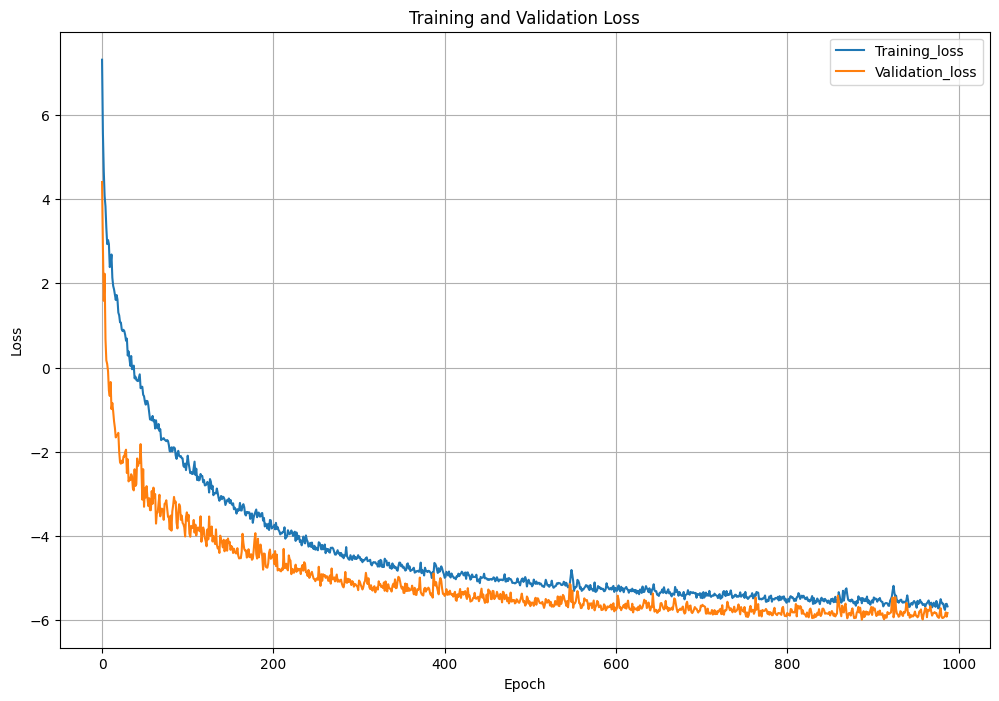

In [18]:
plot_loss(df_history)#, logy=True, ylim=[15, 25])

In [19]:
# prediction of parameters

predictions = model.predict(X_test, verbose=0)
df_predictions = pd.DataFrame(predictions)
y_mean_predict = df_predictions[df_predictions.columns[:5]]
y_sigma_predict = df_predictions[df_predictions.columns[5:]]


df_predictions


,0,1,2,3,4,5,6,7,8,9
0,-0.975701,1.124372,-0.678119,0.868605,0.293055,0.107746,0.557402,0.468585,0.552247,0.037836
1,1.021711,0.011767,0.560516,0.318796,-0.045117,0.255126,0.715115,0.702153,0.687994,0.047746
2,0.615314,0.034517,-0.254033,-0.027518,1.110601,0.300526,0.711248,0.799341,0.874754,0.058038
3,0.507454,-0.300304,0.331187,0.363405,-1.207643,0.321068,0.825634,0.784432,0.736944,0.048768
4,0.134481,-0.290325,0.064727,-0.362289,-1.583420,0.271540,0.751657,0.818825,0.798105,0.054479
...,...,...,...,...,...,...,...,...,...,...
395,0.735347,0.339883,-0.064620,0.487743,-1.447217,0.262847,0.779321,0.729779,0.752457,0.053825
396,1.018747,-0.543160,0.591051,0.288596,1.095174,0.288187,0.788594,0.743528,0.717000,0.063554
397,1.872254,0.456901,0.322771,0.867569,0.690635,0.258868,0.928365,0.645414,0.624785,0.054059
398,0.866413,0.206269,-0.515100,-0.205185,-1.313312,0.322292,0.883194,0.828746,0.728134,0.057027


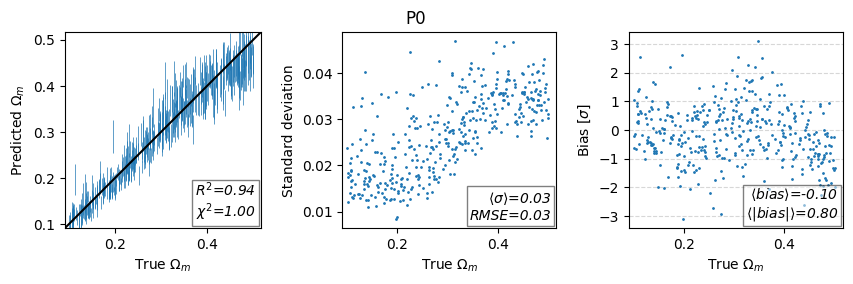

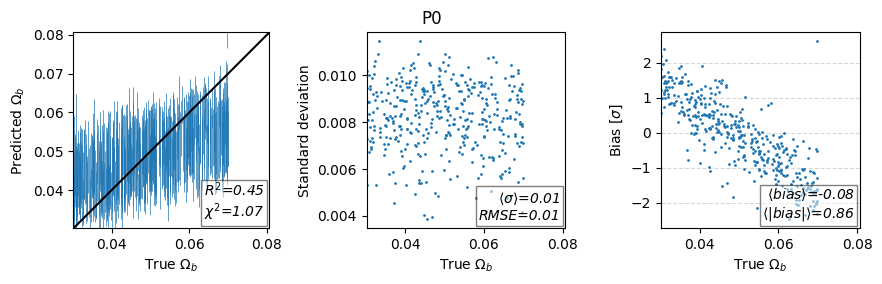

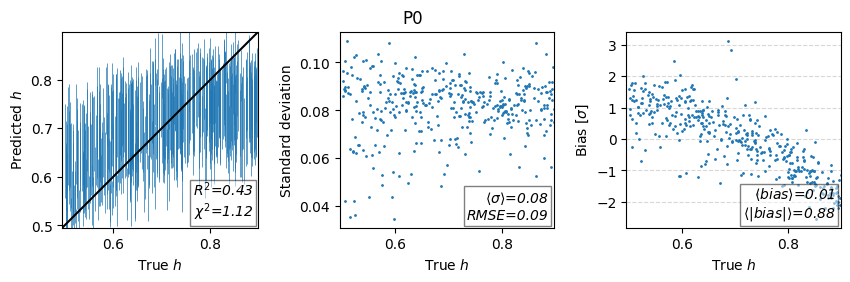

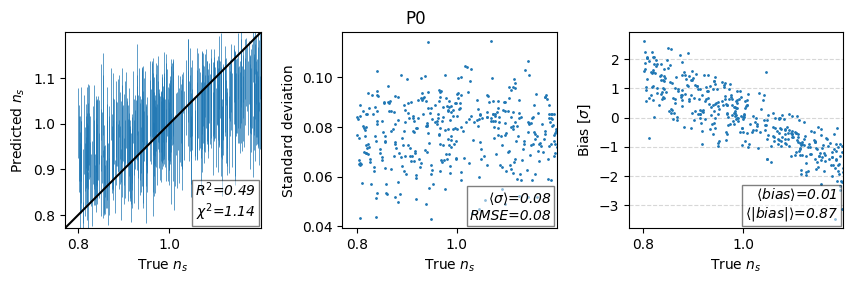

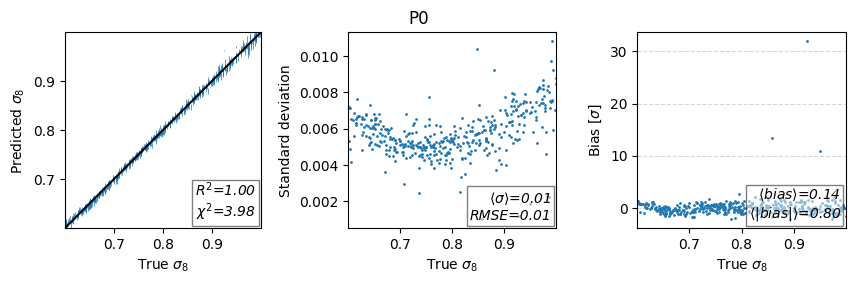

In [20]:
#
true_y = ((y_test * std_params) + mean_params).reset_index(drop=True).values
predict_y = ((y_mean_predict * std_params)  + mean_params).values
predict_E = (y_sigma_predict*std_params).values

for j in range(5):
    check_predictions(
        true_y[:,j],
        predict_y[:,j],
        predict_E[:,j],
        label=label_LaTeX_names_vanilla[j],
        title="P0")
